<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/TRANSFERLEARNING_CROSSTEST_VERBIO_CNN_45SEC_75OL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import zipfile
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
from scipy.stats import mannwhitneyu
from scipy.signal import welch
import ipywidgets as widgets
from IPython.display import display
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.signal import resample
from scipy.signal import find_peaks
import scipy.signal
from scipy.interpolate import interp1d
import glob
from glob import glob
import math

In [ ]:
def read_signal_file(filepath, signal, condition):
    try:
        df = pd.read_csv(filepath, skiprows=1)

        if condition == 'PPT':
            if signal == 'ACC' and df.shape[1] >= 4:
                df = df.iloc[:, 1:4]
                df.columns = ['ACC1', 'ACC2', 'ACC3']
            elif signal in ['BVP', 'EDA', 'TEMP'] and df.shape[1] >= 2:
                df = df.iloc[:, [1]]
                df.columns = [signal]
            else:
                raise ValueError(f"Formato inatteso in {filepath}")
        else:
            if signal == 'ACC' and df.shape[1] == 3:
                df.columns = ['ACC1', 'ACC2', 'ACC3']
            elif signal in ['BVP', 'EDA', 'TEMP'] and df.shape[1] == 1:
                df.columns = [signal]
            else:
                raise ValueError(f"Formato inatteso in {filepath}")

        return df

    except Exception as e:
        print(f"[ERROR] Errore nel file {filepath}: {e}")
        return None

In [ ]:
def upsample_signals(signals_dict, target_freq=64):
    """
    Effettua l'upsampling di ogni segnale nel dizionario signals_dict alla lunghezza massima
    tra tutti i segnali, basata sulla frequenza target.
    """
    max_duration = max(len(signal) for signal in signals_dict.values()) / target_freq
    target_length = int(max_duration * target_freq)

    upsampled_signals = {}
    for name, signal in signals_dict.items():
        resampled_signal = resample(signal, target_length)
        upsampled_signals[name] = resampled_signal

    return pd.DataFrame(upsampled_signals)

In [ ]:
def load_subject_data(subject, base_dir, valid_tests_map):
    phases = ['PRE', 'POST']
    conditions = ['RELAX', 'PPT']
    signals = ['ACC', 'BVP', 'EDA', 'TEMP']
    data = []

    for phase in phases:
        for condition in conditions:
            signal_dict = {}
            for signal in signals:
                file_path = os.path.join(base_dir, phase, "E4", subject, f"{signal}_{condition}.csv")
                df_signal = read_signal_file(file_path, signal, condition)
                if df_signal is not None:
                    for col in df_signal.columns:
                        signal_dict[col] = df_signal[col].values

            if signal_dict:
                df_upsampled = upsample_signals(signal_dict)
                df_upsampled["subject"] = subject
                df_upsampled["session"] = phase
                df_upsampled["phase"] = condition
                data.append(df_upsampled)

    for test_name in valid_tests_map[subject]:
        for condition in conditions:
            signal_dict = {}
            for signal in signals:
                file_path = os.path.join(base_dir, "TEST", test_name, "E4", subject, f"{signal}_{condition}.csv")
                df_signal = read_signal_file(file_path, signal, condition)
                if df_signal is not None:
                    for col in df_signal.columns:
                        signal_dict[col] = df_signal[col].values

            if signal_dict:
                df_upsampled = upsample_signals(signal_dict)
                df_upsampled["subject"] = subject
                df_upsampled["session"] = test_name
                df_upsampled["phase"] = condition
                data.append(df_upsampled)

    if data:
        df_final = pd.concat(data, ignore_index=True)
        signal_cols = ['ACC1', 'ACC2', 'ACC3', 'BVP', 'EDA', 'TEMP']
        meta_cols = ['subject', 'session', 'phase']
        all_cols = [col for col in signal_cols if col in df_final.columns] + meta_cols
        return df_final[all_cols]
    else:
        print(f"Nessun dato caricato per {subject}")
        return pd.DataFrame()

In [ ]:
def load_all_subjects_data(base_dir, complete_subjects_map):
    all_data = []
    for subject, valid_tests in complete_subjects_map.items():
        print(f"Caricamento soggetto {subject} con TEST validi: {valid_tests}")
        df_subject = load_subject_data(subject, base_dir, complete_subjects_map)
        if not df_subject.empty:
            all_data.append(df_subject)
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        print("Nessun dato disponibile per i soggetti completi.")
        return pd.DataFrame()

In [ ]:
base_dir = "/content/drive/MyDrive/VerBIO_Public"

complete_subjects_map = {
    "P005": ["TEST01", "TEST05"],
    "P008": ["TEST01", "TEST05"],
    "P023": ["TEST01", "TEST05"],
    "P032": ["TEST01", "TEST05"],
    "P035": ["TEST01", "TEST05"],
    "P037": ["TEST01", "TEST05"],
    "P038": ["TEST01"],
    "P041": ["TEST01", "TEST05"],
    "P043": ["TEST01"],
    "P044": ["TEST01", "TEST05"],
    "P046": ["TEST01"],
    "P047": ["TEST01", "TEST05"],
    "P049": ["TEST01"],
    "P058": ["TEST01"],
    "P062": ["TEST01", "TEST05"],
    "P065": ["TEST01", "TEST05"],
    "P071": ["TEST01", "TEST05"],
}

df_all = load_all_subjects_data(base_dir, complete_subjects_map)

Caricamento soggetto P005 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P008 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P023 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P032 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P035 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P037 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P038 con TEST validi: ['TEST01']
Caricamento soggetto P041 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P043 con TEST validi: ['TEST01']
Caricamento soggetto P044 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P046 con TEST validi: ['TEST01']
Caricamento soggetto P047 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P049 con TEST validi: ['TEST01']
Caricamento soggetto P058 con TEST validi: ['TEST01']
Caricamento soggetto P062 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P065 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P071 

In [ ]:
df_all.head()

,ACC1,ACC2,ACC3,BVP,EDA,TEMP,subject,session,phase
0,12.000000,13.000000,60.000000,-8.26,0.133470,32.050000,P005,PRE,RELAX
1,5.769194,15.372568,68.929877,-10.13,0.130896,32.054514,P005,PRE,RELAX
2,14.000000,13.000000,61.000000,-12.01,0.128816,32.058249,P005,PRE,RELAX
3,18.849692,12.256620,55.569971,-13.52,0.127238,32.061199,P005,PRE,RELAX
4,15.000000,14.000000,61.000000,-14.26,0.126157,32.063375,P005,PRE,RELAX


In [ ]:
# Calcola le lunghezze dei segnali nella fase PPT per ogni soggetto e sessione
ppt_lengths = (
    df_all[df_all['phase'] == 'PPT']
    .groupby(['subject', 'session'])
    .size()
    .to_dict()
)

In [ ]:
def upsample_fused_column_to_length(fused_values, target_length):
    """
    Esegue il resampling della colonna Fused a una lunghezza target specifica
    utilizzando scipy.signal.resample.
    """
    fused_resampled = resample(fused_values, target_length)
    return fused_resampled


def create_fused_dataset(base_dir, complete_subjects_map, ppt_lengths):
    all_data = []

    for subject, valid_tests in complete_subjects_map.items():
        subject_data = []

        # --- Fasi PRE e POST ---
        for phase in ["PRE", "POST"]:
            anno_path = os.path.join(base_dir, phase, "Annotation", f"{phase}_{subject}_annotation.csv")
            if os.path.exists(anno_path):
                df = pd.read_csv(anno_path)
                if 'Fused' in df.columns:
                    key = (subject, phase)
                    if key in ppt_lengths:
                        target_len = ppt_lengths[key]
                        upsampled = upsample_fused_column_to_length(df['Fused'].values, target_len)
                        df_upsampled = pd.DataFrame({
                            "Fused_score": upsampled,
                            "subject": subject,
                            "session": phase
                        })
                        subject_data.append(df_upsampled)
                    else:
                        print(f"[WARN] Lunghezza non trovata per {key}, saltato.")
                else:
                    print(f"[WARN] Colonna 'Fused' non trovata in {anno_path}")
            else:
                print(f"[WARN] File non trovato: {anno_path}")

        # --- Fase TEST ---
        for test in valid_tests:
            anno_path = os.path.join(base_dir, "TEST", test, "Annotation", f"{test}_{subject}_annotation.csv")
            if os.path.exists(anno_path):
                df = pd.read_csv(anno_path)
                if 'Fused' in df.columns:
                    key = (subject, test)
                    if key in ppt_lengths:
                        target_len = ppt_lengths[key]
                        upsampled = upsample_fused_column_to_length(df['Fused'].values, target_len)
                        df_upsampled = pd.DataFrame({
                            "Fused_score": upsampled,
                            "subject": subject,
                            "session": test
                        })
                        subject_data.append(df_upsampled)
                    else:
                        print(f"[WARN] Lunghezza non trovata per {key}, saltato.")
                else:
                    print(f"[WARN] Colonna 'Fused' non trovata in {anno_path}")
            else:
                print(f"[WARN] File non trovato: {anno_path}")

        # --- Aggregazione per soggetto ---
        if subject_data:
            all_data.append(pd.concat(subject_data, ignore_index=True))

    # --- Dataset finale ---
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        print("Nessun dato disponibile.")
        return pd.DataFrame()

In [ ]:
complete_subjects_map = {
    "P005": ["TEST01", "TEST05"],
    "P008": ["TEST01", "TEST05"],
    "P023": ["TEST01", "TEST05"],
    "P032": ["TEST01", "TEST05"],
    "P035": ["TEST01", "TEST05"],
    "P037": ["TEST01", "TEST05"],
    "P038": ["TEST01"],
    "P041": ["TEST01", "TEST05"],
    "P043": ["TEST01"],
    "P044": ["TEST01", "TEST05"],
    "P046": ["TEST01"],
    "P047": ["TEST01", "TEST05"],
    "P049": ["TEST01"],
    "P058": ["TEST01"],
    "P062": ["TEST01", "TEST05"],
    "P065": ["TEST01", "TEST05"],
    "P071": ["TEST01", "TEST05"]
}

base_dir = "/content/drive/MyDrive/VerBIO_Public"

subjects_annotation = create_fused_dataset(base_dir, complete_subjects_map, ppt_lengths)

In [ ]:
subjects_annotation.head()

,Fused_score,subject,session
0,0.005876,P005,PRE
1,0.001657,P005,PRE
2,-0.002391,P005,PRE
3,-0.006267,P005,PRE
4,-0.009969,P005,PRE


In [ ]:
subjects_annotation.groupby(['subject', 'session']).size()

subject  session
P005     POST       16850
         PRE        11271
         TEST01     13275
         TEST05     10887
P008     POST       15789
         PRE        18469
         TEST01     11794
         TEST05     10091
P023     POST       13929
         PRE        16087
         TEST01     14068
         TEST05     13993
P032     POST       19454
         PRE        18696
         TEST01     14401
         TEST05     14962
P035     POST       19109
         PRE        18948
         TEST01     23255
         TEST05     19230
P037     POST       14530
         PRE        12265
         TEST01     17709
         TEST05     12849
P038     POST        9454
         PRE         8075
         TEST01     18882
P041     POST       15429
         PRE        18102
         TEST01     14767
         TEST05      8290
P043     POST       19277
         PRE        18949
         TEST01     13515
P044     POST       14810
         PRE        17773
         TEST01     10581
         TEST05      8316
P046     POST       21849
         PRE        18610
         TEST01     20726
P047     POST       18985
         PRE        12561
         TEST01     20784
         TEST05     17734
P049     POST       17490
         PRE        19057
         TEST01     11899
P058     POST       19059
         PRE        19038
         TEST01     16649
P062     POST       13421
         PRE        14109
         TEST01     16732
         TEST05     11356
P065     POST       15458
         PRE        19186
         TEST01     19955
         TEST05     14294
P071     POST       15841
         PRE        17998
         TEST01     14709
         TEST05      9709
dtype: int64

In [ ]:
df_all[df_all['phase'] == 'PPT'].groupby(['subject', 'session']).size()

subject  session
P005     POST       16850
         PRE        11271
         TEST01     13275
         TEST05     10887
P008     POST       15789
         PRE        18469
         TEST01     11794
         TEST05     10091
P023     POST       13929
         PRE        16087
         TEST01     14068
         TEST05     13993
P032     POST       19454
         PRE        18696
         TEST01     14401
         TEST05     14962
P035     POST       19109
         PRE        18948
         TEST01     23255
         TEST05     19230
P037     POST       14530
         PRE        12265
         TEST01     17709
         TEST05     12849
P038     POST        9454
         PRE         8075
         TEST01     18882
P041     POST       15429
         PRE        18102
         TEST01     14767
         TEST05      8290
P043     POST       19277
         PRE        18949
         TEST01     13515
P044     POST       14810
         PRE        17773
         TEST01     10581
         TEST05      8316
P046     POST       21849
         PRE        18610
         TEST01     20726
P047     POST       18985
         PRE        12561
         TEST01     20784
         TEST05     17734
P049     POST       17490
         PRE        19057
         TEST01     11899
P058     POST       19059
         PRE        19038
         TEST01     16649
P062     POST       13421
         PRE        14109
         TEST01     16732
         TEST05     11356
P065     POST       15458
         PRE        19186
         TEST01     19955
         TEST05     14294
P071     POST       15841
         PRE        17998
         TEST01     14709
         TEST05      9709
dtype: int64

In [ ]:
def label_dataset(df_signals, df_annotations, threshold=0.2):
    """
    Etichetta il dataset dei segnali:
    - label = 0 per tutti i record nella fase RELAX
    - label = 1 per i valori in fase PPT dove il Fused_score > threshold
      altrimenti 0.
    """
    # Inizializza colonna label con zeri
    df_signals['label'] = 0

    # Trova tutte le righe in fase PPT
    mask_ppt = df_signals['phase'] == 'PPT'
    df_ppt = df_signals[mask_ppt]

    # Etichettatura per soggetto e session
    for (subject, session), group in df_ppt.groupby(['subject', 'session']):
        # Estrai fused score allineato
        fused_values = df_annotations[
            (df_annotations['subject'] == subject) &
            (df_annotations['session'] == session)
        ]['Fused_score'].values

        # Protezione contro mismatch
        signal_idx = df_signals[
            (df_signals['subject'] == subject) &
            (df_signals['session'] == session) &
            (df_signals['phase'] == 'PPT')
        ].index

        if len(signal_idx) == len(fused_values):
            df_signals.loc[signal_idx, 'label'] = (fused_values > threshold).astype(int)
        else:
            print(f"[WARN] Mismatch di lunghezza per {subject} - {session}: "
                  f"{len(signal_idx)} vs {len(fused_values)}")

    return df_signals

In [ ]:
df = label_dataset(df_all, subjects_annotation)

In [ ]:
df.head()

,ACC1,ACC2,ACC3,BVP,EDA,TEMP,subject,session,phase,label
0,12.000000,13.000000,60.000000,-8.26,0.133470,32.050000,P005,PRE,RELAX,0
1,5.769194,15.372568,68.929877,-10.13,0.130896,32.054514,P005,PRE,RELAX,0
2,14.000000,13.000000,61.000000,-12.01,0.128816,32.058249,P005,PRE,RELAX,0
3,18.849692,12.256620,55.569971,-13.52,0.127238,32.061199,P005,PRE,RELAX,0
4,15.000000,14.000000,61.000000,-14.26,0.126157,32.063375,P005,PRE,RELAX,0


LABEL DISTRIBUTION ANALYSIS

In [ ]:
freq_absolute_global = df["label"].value_counts()
freq_relative_global = df["label"].value_counts(normalize=True)

global_distribution = pd.DataFrame({
    'Frequenza Assoluta': freq_absolute_global,
    'Frequenza Relativa (%)': (freq_relative_global * 100).round(2)
})

global_distribution

,Frequenza Assoluta,Frequenza Relativa (%)
label,,
0,1479091,68.49
1,680521,31.51


In [ ]:
ppt_df = df[df['phase'] == 'PPT']

phase_distribution = ppt_df.groupby(['session', 'label']).size().unstack(fill_value=0)

phase_distribution['Totale'] = phase_distribution.sum(axis=1)
phase_distribution['% Label 0'] = ((phase_distribution[0] / phase_distribution['Totale']) * 100).round(2)
phase_distribution['% Label 1'] = ((phase_distribution[1] / phase_distribution['Totale']) * 100).round(2)

phase_distribution = phase_distribution[['Totale', 0, 1, '% Label 0', '% Label 1']]
phase_distribution.columns = ['Totale', 'Label 0', 'Label 1', 'Label 0 (%)', 'Label 1 (%)']

phase_distribution

,Totale,Label 0,Label 1,Label 0 (%),Label 1 (%)
session,,,,,
POST,280734,103500,177234,36.87,63.13
PRE,279194,83905,195289,30.05,69.95
TEST01,273701,65028,208673,23.76,76.24
TEST05,151711,52386,99325,34.53,65.47


In [ ]:
# Raggruppa per soggetto e label nella fase PPT
etichetta_ppt = df[df['phase'] == 'PPT'].groupby(['subject', 'label']).size().unstack(fill_value=0)

# Rinomina le colonne per chiarezza
etichetta_ppt.columns = ['Label 0 (Baseline)', 'Label 1 (Stress)']

# Aggiungi anche una colonna con il totale
etichetta_ppt['Totale'] = etichetta_ppt.sum(axis=1)

# Ordina per soggetti con più label 1 (stress)
etichetta_ppt = etichetta_ppt.sort_values(by='Label 1 (Stress)', ascending=False)

pd.set_option('display.max_rows', None)  # opzionale: mostra tutti i soggetti
etichetta_ppt

,Label 0 (Baseline),Label 1 (Stress),Totale
subject,,,
P047,1451,68613,70064
P032,3025,64488,67513
P041,2070,54518,56588
P071,4869,53388,58257
P062,2399,53219,55618
P058,2549,52197,54746
P043,3080,48661,51741
P023,11647,46430,58077
P005,6765,45518,52283


In [ ]:
def remove_subjects_without_positive_labels(df, label_col='label', subject_col='subject'):
    """
    Rimuove tutti i datapoint dei soggetti che non hanno nessuna etichetta positiva (label == 1).

    Parameters:
        df (pd.DataFrame): Il dataset completo.
        label_col (str): Il nome della colonna delle etichette.
        subject_col (str): Il nome della colonna dei soggetti.

    Returns:
        df_filtered (pd.DataFrame): Il dataframe filtrato.
        removed_subjects (list): Lista dei soggetti rimossi.
    """
    # Trova i soggetti che hanno almeno una label == 1
    subjects_with_positive = df[df[label_col] == 1][subject_col].unique()

    # Trova i soggetti che NON hanno etichette positive
    all_subjects = df[subject_col].unique()
    removed_subjects = sorted(list(set(all_subjects) - set(subjects_with_positive)))

    # Filtra il dataframe per rimuovere i soggetti da escludere
    df_filtered = df[~df[subject_col].isin(removed_subjects)].reset_index(drop=True)

    return df_filtered, removed_subjects

In [ ]:
df, soggetti_rimossi = remove_subjects_without_positive_labels(df)

print("Soggetti rimossi:", soggetti_rimossi)

Soggetti rimossi: []


In [ ]:
pip install neurokit2

In [ ]:
import neurokit2 as nk

In [ ]:
ppg_raw = df["BVP"].values

fs = 64

ppg_signals, ppg_info = nk.ppg_process(ppg_raw, sampling_rate=fs)

ppg_clean = ppg_signals["PPG_Clean"]

df['BVP_CLEAN'] = ppg_clean

In [ ]:
eda_raw = df["EDA"].values

fs = 64

eda_signals, eda_info = nk.eda_process(eda_raw, sampling_rate=fs)

eda_clean = eda_signals["EDA_Clean"]

df['EDA_CLEAN'] = eda_clean

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def acc_denoise(acc_signal, fs):

    b_high, a_high = butter_highpass(0.5, fs)
    acc_signal = filtfilt(b_high, a_high, acc_signal)

    b_low, a_low = butter_lowpass(20.0, fs)
    acc_signal = filtfilt(b_low, a_low, acc_signal)

    return acc_signal

In [ ]:
df['ACC_MAG'] = np.sqrt(df['ACC1']**2+df['ACC2']**2+df['ACC3']**2)
df = df.drop(columns = ['ACC1', 'ACC2', 'ACC3'], axis = 1)

In [ ]:
fs = 64
df['ACC_MAG_CLEAN'] = acc_denoise(df['ACC_MAG'].values, fs)

In [ ]:
def temp_denoise(temp_signal, fs):
  b_low, a_low = butter_lowpass(0.5, fs)
  temp_signal = filtfilt(b_low, a_low, temp_signal)
  return temp_signal

In [ ]:
fs = 64
df['TEMP_CLEAN'] = temp_denoise(df['TEMP'].values, fs)

In [ ]:
fs = 64
win_sec = 45
overlap = 0.75
win_size = fs * win_sec
step_size = win_size // 2

In [ ]:
def create_windowed_array_per_signal(df, signal_col, fs=64, win_sec=45, overlap=0.75, threshold=0.7):
    win_size = int(fs * win_sec)
    step_size = int(win_size * (1 - overlap))

    X = []
    y = []
    groups = []

    for subject_id in df['subject'].unique():
        df_subj = df[df['subject'] == subject_id].reset_index(drop=True)
        signal = df_subj[signal_col].values.astype(np.float32)
        labels = df_subj['label'].values.astype(int)

        for start in range(0, len(signal) - win_size + 1, step_size):
            end = start + win_size
            window = signal[start:end]
            window_labels = labels[start:end]

            # Conta le occorrenze di ciascuna label nella finestra
            counts = np.bincount(window_labels, minlength=2)
            total = np.sum(counts)
            dominant_label = np.argmax(counts)
            dominant_ratio = counts[dominant_label] / total

            # Condizione: label dominante deve essere almeno il 70%
            if dominant_ratio >= threshold:
                X.append(window)
                y.append(dominant_label)
                groups.append(subject_id)

    X = np.array(X)[..., np.newaxis]  # aggiungi dimensione canale per CNN
    y = np.array(y).astype(int)
    groups = np.array(groups)

    return X, y, groups

In [ ]:
 segnali = ['BVP_CLEAN', 'EDA_CLEAN', 'ACC_MAG_CLEAN', 'TEMP_CLEAN']

In [ ]:
X_dict = {}
for segnale in segnali:
    print(f"Processing {segnale}...")
    X, y_raw, groups = create_windowed_array_per_signal(
        df, signal_col=segnale, fs=fs, win_sec=win_sec, overlap=overlap, threshold=0.7
    )

    if segnale == segnali[0]:
        y = y_raw
        group_labels = groups

    X_dict[segnale] = X

Processing BVP_CLEAN...
Processing EDA_CLEAN...
Processing ACC_MAG_CLEAN...
Processing TEMP_CLEAN...


In [ ]:
for segnale in segnali:
  print(f"Tipo: {type(X_dict[segnale])} Dimensione {segnale}: {X_dict[segnale].shape}")

Tipo: <class 'numpy.ndarray'> Dimensione BVP_CLEAN: (2658, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione EDA_CLEAN: (2658, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione ACC_MAG_CLEAN: (2658, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione TEMP_CLEAN: (2658, 2880, 1)


In [ ]:
print(f"Tipo: {type(y)} Dimensione y: {y.shape}")

Tipo: <class 'numpy.ndarray'> Dimensione y: (2658,)


In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1887,  771]))

In [ ]:
for seg in segnali:
    print(f"{seg}: {X_dict[seg].dtype}")

BVP_CLEAN: float32
EDA_CLEAN: float32
ACC_MAG_CLEAN: float32
TEMP_CLEAN: float32


CAMPANELLA --> VERBIO

CROSS TEST CAMPANELLA CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.9159
Soggetto migliore: subject_22

CROSS TEST: CAMPANELLA MODEL → VERBIO DATASET
Inizio valutazione cross-test...
  Fold  1 - P005: F1=0.765 Acc=0.797
  Fold  2 - P008: F1=0.329 Acc=0.696
  Fold  3 - P023: F1=0.860 Acc=0.892
  Fold  4 - P032: F1=0.321 Acc=0.573
  Fold  5 - P035: F1=0.078 Acc=0.660
  Fold  6 - P037: F1=0.152 Acc=0.576
  Fold  7 - P038: F1=0.400 Acc=0.547
  Fold  8 - P041: F1=0.800 Acc=0.854
  Fold  9 - P043: F1=0.846 Acc=0.853
  Fold 10 - P044: F1=0.294 Acc=0.667
  Fold 11 - P046: F1=0.456 Acc=0.639
  Fold 12 - P047: F1=0.578 Acc=0.697
  Fold 13 - P049: F1=0.454 Acc=0.551
  Fold 14 - P058: F1=0.803 Acc=0.840
  Fold 15 - P062: F1=0.059 Acc=0.597
  Fold 16 - P065: F1=0.377 Acc=0.609
  Fold 17 - P071: F1=0.829 Acc=0.857

--------------------------------------------------
RISULTATI CROSS TEST
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   

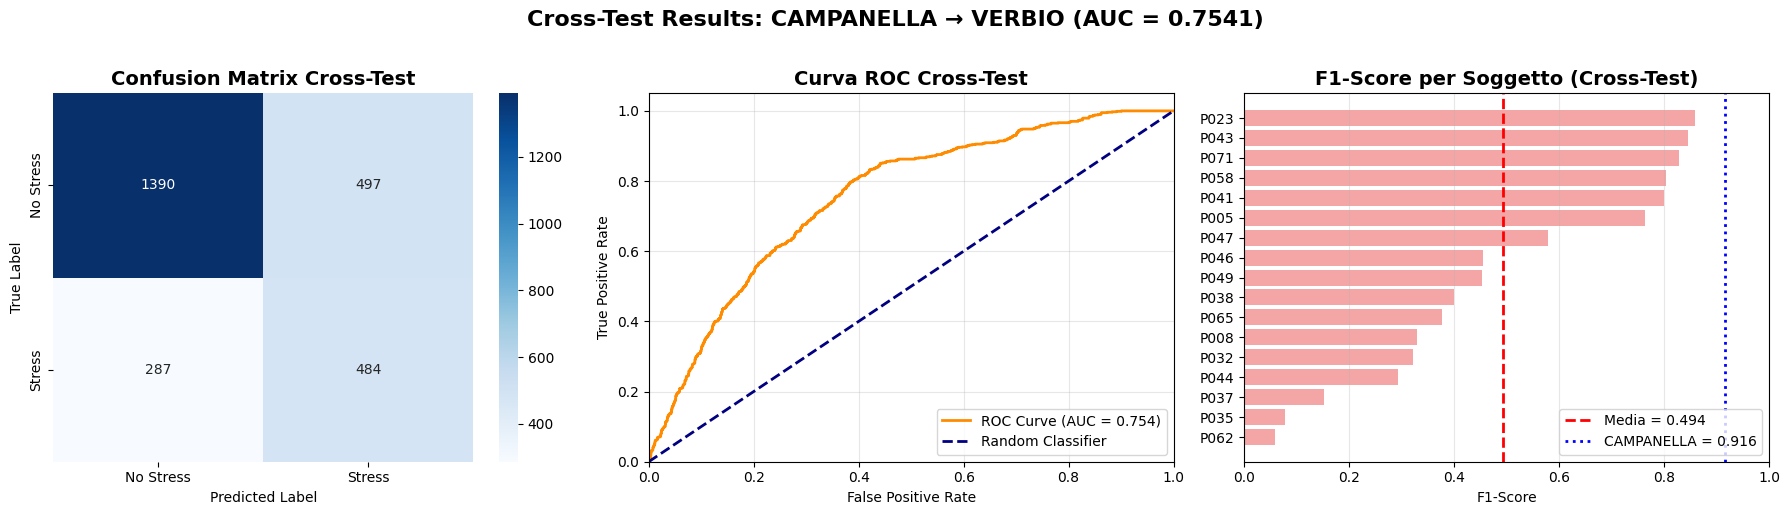


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/campanella_to_verbio_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/campanella_to_verbio_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: CAMPANELLA MODEL SU VERBIO CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO CAMPANELLA
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello CAMPANELLA
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/CAMPANELLA"
campanella_model, campanella_scalers, campanella_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: CAMPANELLA MODEL → VERBIO DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (Verbio)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler CAMPANELLA
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler CAMPANELLA
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = campanella_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello CAMPANELLA
    try:
        y_pred_proba = campanella_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello CAMPANELLA
        threshold = campanella_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale CAMPANELLA:")
    print(f"F1 CAMPANELLA:     {campanella_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - campanella_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance CAMPANELLA originale
        axes[2].axvline(x=campanella_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'CAMPANELLA = {campanella_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: CAMPANELLA → VERBIO (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "campanella_to_verbio_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'CAMPANELLA',
        'target_dataset': 'VERBIO',
        'source_f1': float(campanella_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(campanella_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "campanella_to_verbio_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING CAMPANELLA CNN

✓ Modello CAMPANELLA.keras caricato
✓ Scalers CAMPANELLA caricati
=== CAMPANELLA MODEL INFO ===
F1-Score: 0.9158878504672897
Best Subject: subject_22

TRANSFER LEARNING: CAMPANELLA → VERBIO
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - P005: F1=0.887 (8ep)
  Fold  2 - P008: F1=0.347 (8ep)
  Fold  3 - P023: 

F1=0.897 (8ep)
  Fold  4 - P032: 

F1=0.726 (5ep)
  Fold  5 - P035: F1=0.054 (6ep)
  Fold  6 - P037: F1=0.244 (8ep)
  Fold  7 - P038: F1=0.667 (6ep)
  Fold  8 - P041: F1=0.803 (8ep)
  Fold  9 - P043: F1=0.882 (5ep)
  Fold 10 - P044: F1=0.634 (7ep)
  Fold 11 - P046: F1=0.500 (8ep)
  Fold 12 - P047: F1=0.782 (5ep)
  Fold 13 - P049: F1=0.605 (8ep)
  Fold 14 - P058: F1=0.918 (5ep)
  Fold 15 - P062: F1=0.561 (5ep)
  Fold 16 - P065: F1=0.442 (6ep)
  Fold 17 - P071: F1=0.878 (8ep)

--------------------------------------------------
RISULTATI TRANSFER LEARNING
--------------------------------------------------
Fold con class collapse: 0/17
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score  predicted_classes
   P005        158    0.9241     0.8704  0.9038    0.8868                  2
   P008        161    0.6957     0.2167  0.8667    0.3467                  2
   P023        148    0.9257     0.8276  0.9796    0.8972                  2
   P032        178    0.6517     0.5734  0.9880    0.7257      

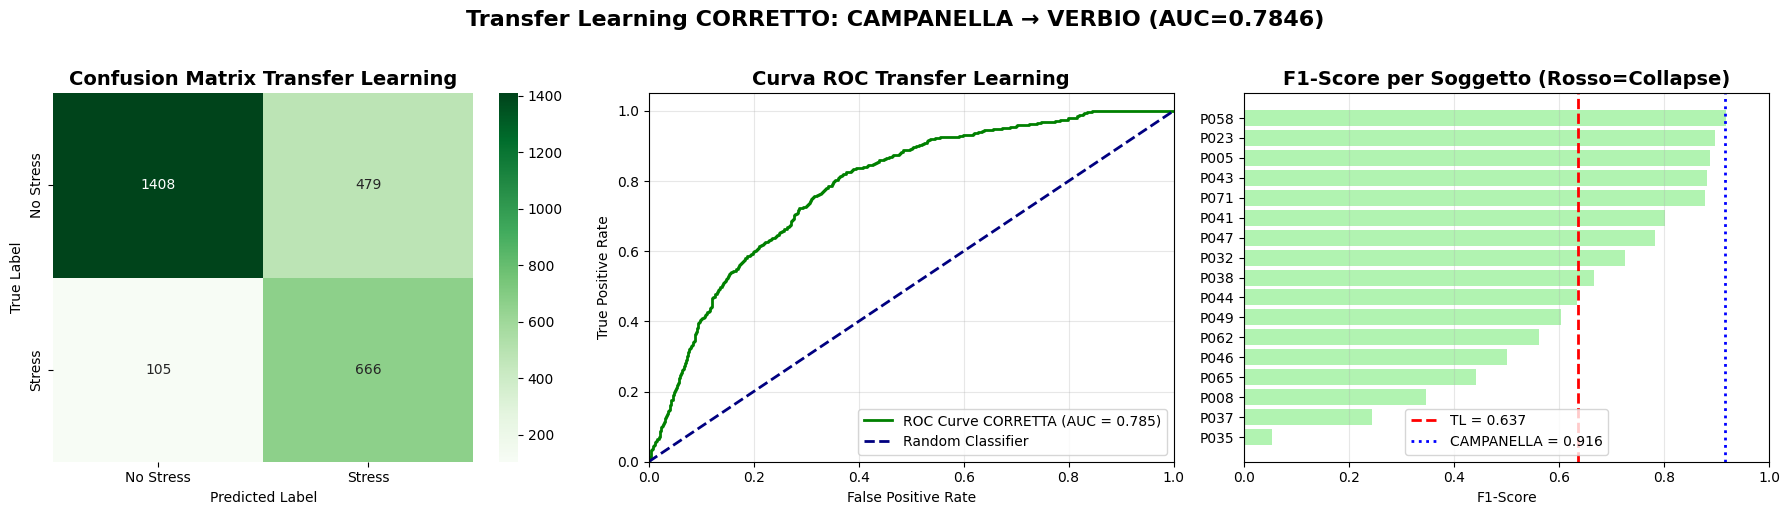


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/VERBIO/CAMPANELLA_TO_VERBIO_RESULTS_FIXED/campanella_to_verbio_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/VERBIO/CAMPANELLA_TO_VERBIO_RESULTS_FIXED/campanella_to_verbio_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: CAMPANELLA → VERBIO CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO CAMPANELLA
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV CAMPANELLA se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV CAMPANELLA: {e}")
    return None

def load_source_model(model_dir, dataset_name="CAMPANELLA"):
    """Carica modello sorgente CAMPANELLA con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello CAMPANELLA
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON CAMPANELLA corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello CAMPANELLA!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers CAMPANELLA
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente CAMPANELLA
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/CAMPANELLA"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "CAMPANELLA")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: CAMPANELLA → VERBIO")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (VERBIO)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per CAMPANELLA
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/VERBIO/CAMPANELLA_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER CAMPANELLA (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER CAMPANELLA ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler CAMPANELLA
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"CAMPANELLA originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'CAMPANELLA = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: CAMPANELLA → VERBIO (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/VERBIO/CAMPANELLA_TO_VERBIO_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "campanella_to_verbio_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'CAMPANELLA',
        'target_dataset': 'VERBIO',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "campanella_to_verbio_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")

WESAD --> VERBIO

CROSS TEST WESAD CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.9910
Soggetto migliore: S8

CROSS TEST: WESAD MODEL → VERBIO DATASET
Inizio valutazione cross-test...
  Fold  1 - P005: F1=0.926 Acc=0.949
  Fold  2 - P008: F1=0.000 Acc=0.820
  Fold  3 - P023: F1=0.864 Acc=0.919
  Fold  4 - P032: F1=0.582 Acc=0.573
  Fold  5 - P035: F1=0.000 Acc=0.679
  Fold  6 - P037: F1=0.263 Acc=0.823
  Fold  7 - P038: F1=0.552 Acc=0.632
  Fold  8 - P041: F1=0.696 Acc=0.830
  Fold  9 - P043: F1=0.733 Acc=0.791
  Fold 10 - P044: F1=0.000 Acc=0.667
  Fold 11 - P046: F1=0.459 Acc=0.723
  Fold 12 - P047: F1=0.000 Acc=0.511
  Fold 13 - P049: F1=0.327 Acc=0.720
  Fold 14 - P058: F1=0.187 Acc=0.593
  Fold 15 - P062: F1=0.000 Acc=0.585
  Fold 16 - P065: F1=0.437 Acc=0.710
  Fold 17 - P071: F1=0.113 Acc=0.625

--------------------------------------------------
RISULTATI CROSS TEST
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   P005        1

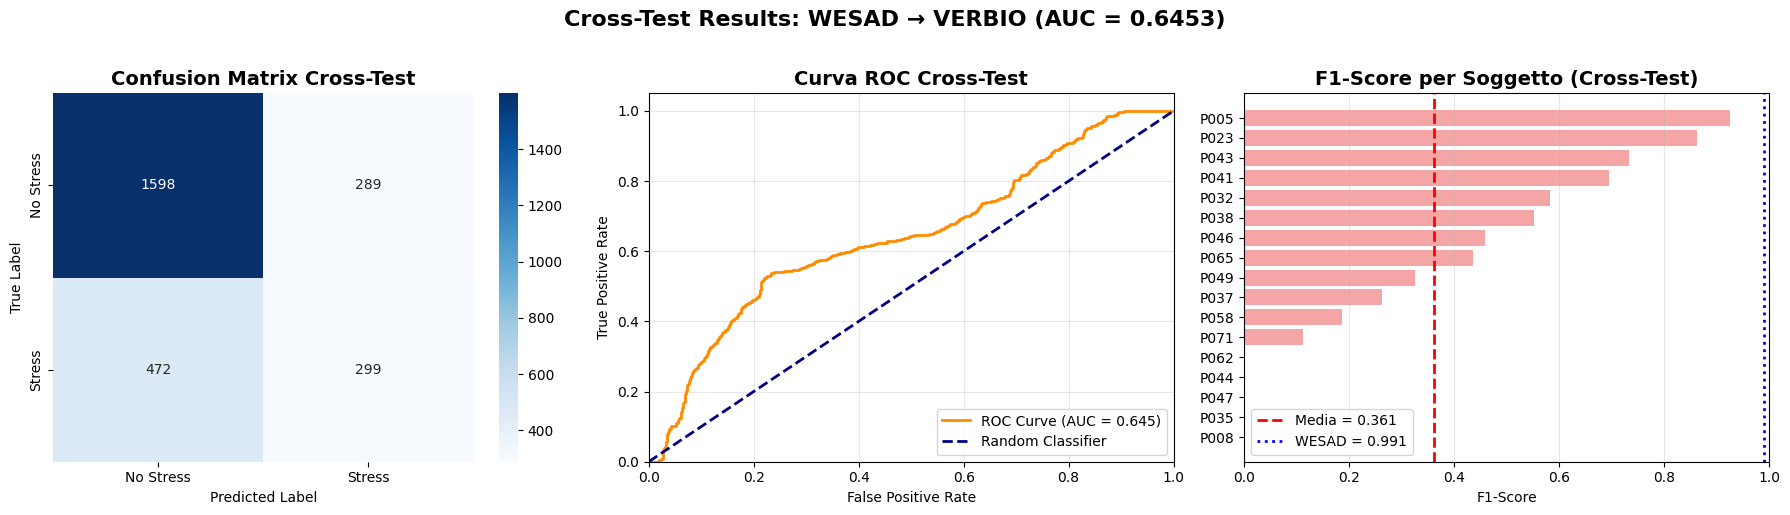


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/wesad_to_verbio_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/wesad_to_verbio_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: WESAD MODEL SU VERBIO CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO WESAD
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello WESAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/WESAD"
wesad_model, wesad_scalers, wesad_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: WESAD MODEL → VERBIO DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (VERBIO)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler WESAD
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler WESAD
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = wesad_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello WESAD
    try:
        y_pred_proba = wesad_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello WESAD
        threshold = wesad_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale WESAD:")
    print(f"F1 WESAD:     {wesad_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - wesad_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance WESAD originale
        axes[2].axvline(x=wesad_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'WESAD = {wesad_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: WESAD → VERBIO (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "wesad_to_verbio_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'WESAD',
        'target_dataset': 'VERBIO',
        'source_f1': float(wesad_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(wesad_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "wesad_to_verbio_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING WESAD CNN

✓ Modello WESAD.keras caricato
✓ Scalers WESAD caricati
=== WESAD MODEL INFO ===
F1-Score: 0.990990990990991
Best Subject: S8

TRANSFER LEARNING: WESAD → VERBIO
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - P005: F1=0.919 (5ep)
  Fold  2 - P008: F1=0.182 (5ep)
  Fold  3 - P023: 

F1=0.929 (5ep)
  Fold  4 - P032: 

F1=0.667 (7ep)
  Fold  5 - P035: F1=0.047 (8ep)
  Fold  6 - P037: F1=0.533 (5ep)
  Fold  7 - P038: F1=0.582 (8ep)
  Fold  8 - P041: F1=0.825 (5ep)
  Fold  9 - P043: F1=0.785 (5ep)
  Fold 10 - P044: F1=0.369 (6ep)
  Fold 11 - P046: F1=0.554 (8ep)
  Fold 12 - P047: F1=0.425 (6ep)
  Fold 13 - P049: F1=0.547 (8ep)
  Fold 14 - P058: F1=0.871 (6ep)
  Fold 15 - P062: F1=0.670 (6ep)
  Fold 16 - P065: F1=0.422 (8ep)
  Fold 17 - P071: F1=0.773 (6ep)

--------------------------------------------------
RISULTATI TRANSFER LEARNING
--------------------------------------------------
Fold con class collapse: 0/17
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score  predicted_classes
   P005        158    0.9430     0.8644  0.9808    0.9189                  2
   P008        161    0.2174     0.1007  0.9333    0.1818                  2
   P023        148    0.9527     0.9200  0.9388    0.9293                  2
   P032        178    0.6348     0.5804  0.7831    0.6667      

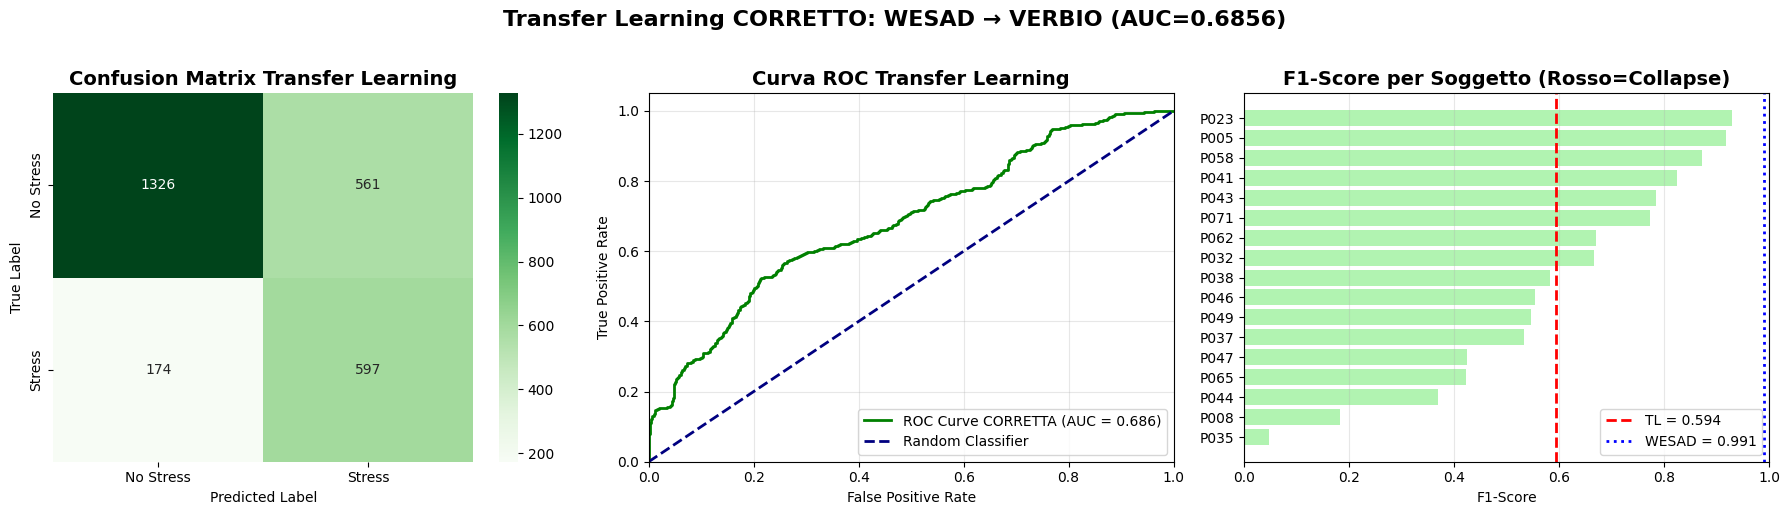


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/VERBIO/WESAD_TO_VERBIO_RESULTS_FIXED/wesad_to_verbio_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/VERBIO/WESAD_TO_VERBIO_RESULTS_FIXED/wesad_to_verbio_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: WESAD → VERBIO CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO WESAD
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV WESAD se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV WESAD: {e}")
    return None

def load_source_model(model_dir, dataset_name="WESAD"):
    """Carica modello sorgente WESAD con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello WESAD
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON WESAD corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello WESAD!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers WESAD
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente WESAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/WESAD"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "WESAD")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: WESAD → VERBIO")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (VERBIO)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per VERBIO
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/VERBIO/WESAD_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER WESAD (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER WESAD ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler WESAD
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"WESAD originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'WESAD = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: WESAD → VERBIO (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/VERBIO/WESAD_TO_VERBIO_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "wesad_to_verbio_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'WESAD',
        'target_dataset': 'VERBIO',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "wesad_to_verbio_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")

AFFECTIVE ROAD --> VERBIO

CROSS TEST AFFECTIVE ROAD CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.8360
Soggetto migliore: Drv3

CROSS TEST: AFFECTIVE ROAD MODEL → VERBIO DATASET
Inizio valutazione cross-test...
  Fold  1 - P005: F1=0.847 Acc=0.886
  Fold  2 - P008: F1=0.325 Acc=0.665
  Fold  3 - P023: F1=0.838 Acc=0.872
  Fold  4 - P032: F1=0.022 Acc=0.506
  Fold  5 - P035: F1=0.079 Acc=0.665
  Fold  6 - P037: F1=0.179 Acc=0.652
  Fold  7 - P038: F1=0.240 Acc=0.642
  Fold  8 - P041: F1=0.733 Acc=0.830
  Fold  9 - P043: F1=0.871 Acc=0.876
  Fold 10 - P044: F1=0.154 Acc=0.694
  Fold 11 - P046: F1=0.435 Acc=0.672
  Fold 12 - P047: F1=0.550 Acc=0.697
  Fold 13 - P049: F1=0.524 Acc=0.661
  Fold 14 - P058: F1=0.814 Acc=0.853
  Fold 15 - P062: F1=0.000 Acc=0.579
  Fold 16 - P065: F1=0.364 Acc=0.586
  Fold 17 - P071: F1=0.821 Acc=0.857

--------------------------------------------------
RISULTATI CROSS TEST
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   P0

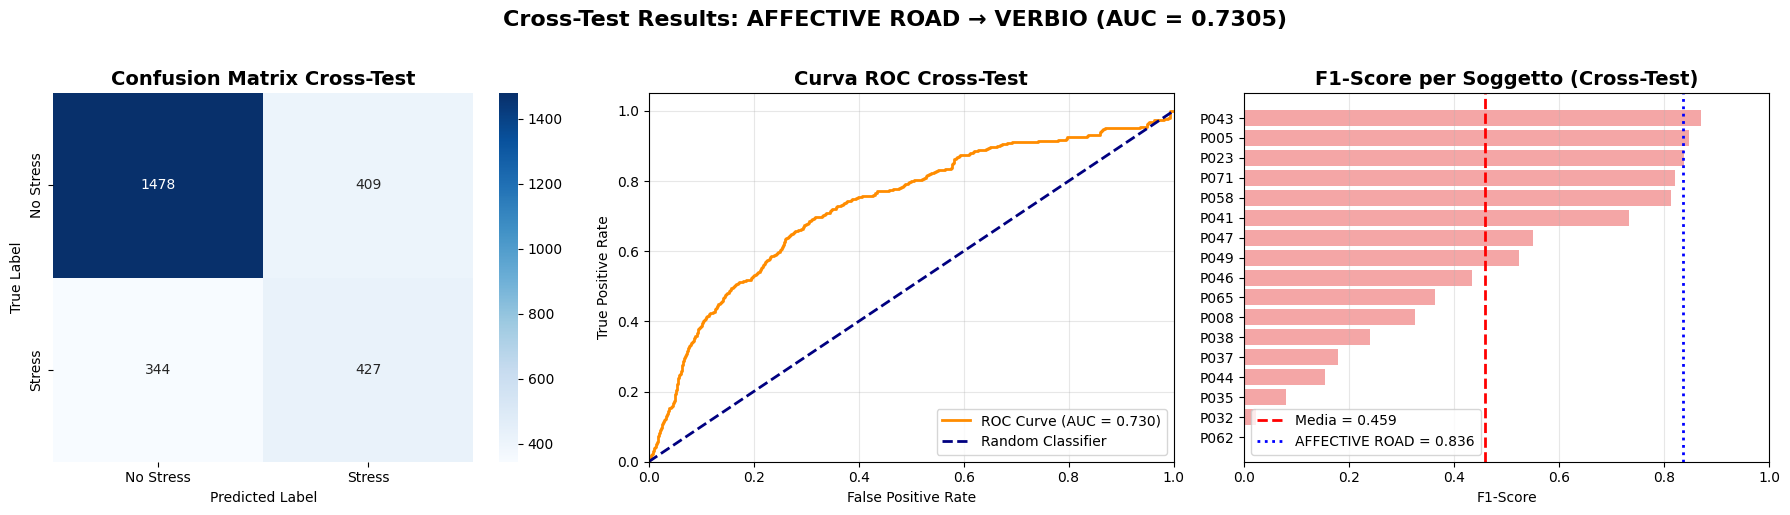


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/affectiveroad_to_verbio_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/affectiveroad_to_verbio_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: AFFECTIVE ROAD MODEL SU VERBIO CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO AFFECTIVE ROAD
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello AFFECTIVE ROAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/AFFECTIVE ROAD"
affectiveroad_model, affectiveroad_scalers, affectiveroad_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: AFFECTIVE ROAD MODEL → VERBIO DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (VERBIO)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler AFFECTIVE ROAD
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler AFFECTIVE ROAD
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = affectiveroad_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello AFFECTIVE ROAD
    try:
        y_pred_proba = affectiveroad_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello AFFECTIVE ROAD
        threshold = affectiveroad_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale AFFECTIVE ROAD:")
    print(f"F1 AFFECTIVE ROAD:     {affectiveroad_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - affectiveroad_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance AFFECTIVE ROAD originale
        axes[2].axvline(x=affectiveroad_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'AFFECTIVE ROAD = {affectiveroad_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: AFFECTIVE ROAD → VERBIO (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "affectiveroad_to_verbio_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'AFFECTIVE ROAD',
        'target_dataset': 'VERBIO',
        'source_f1': float(affectiveroad_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(affectiveroad_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "affectiveroad_to_verbio_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING AFFECTIVE ROAD CNN

✓ Modello AFFECTIVE ROAD.keras caricato
✓ Scalers AFFECTIVE ROAD caricati
=== AFFECTIVE ROAD MODEL INFO ===
F1-Score: 0.8359788359788359
Best Subject: Drv3

TRANSFER LEARNING: AFFECTIVE ROAD → VERBIO
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - P005: F1=0.850 (5ep)
  Fold  2 - P008: F1=0.341 (6ep)
  Fold  3 - P023: F1=0.970 (5ep)
  Fold  4 - P032: F1=0.729 (5ep)
  Fold  5 - P035: F1=0.062 (8ep)
  Fold  6 - P037: F1=0.615 (8ep)
  Fold  7 - P038: F1=0.505 (8ep)
  Fold  8 - P041: F1=0.789 (6ep)
  Fold  9 - P043: F1=0.884 (5ep)
  Fold 10 - P044: F1=0.615 (5ep)
  Fold 11 - P046: F1=0.523 (5ep)
  Fold 12 - P047: F1=0.807 (5ep)
  Fold 13 - P049: F1=0.583 (6ep)
  Fold 14 - P058: F1=0.817 (8ep)
  Fold 15 - P062: F1=0.590 (8ep)
  Fold 16 - P065: F1=0.427 (8ep)
  Fold 17 - P071: F1=0.871 (5ep)

--------------------------------------------------
RISULTATI TRANSFER LEARNING
--------------------------------------------------
Fold con class collapse: 0/17
Risultati per soggetto:

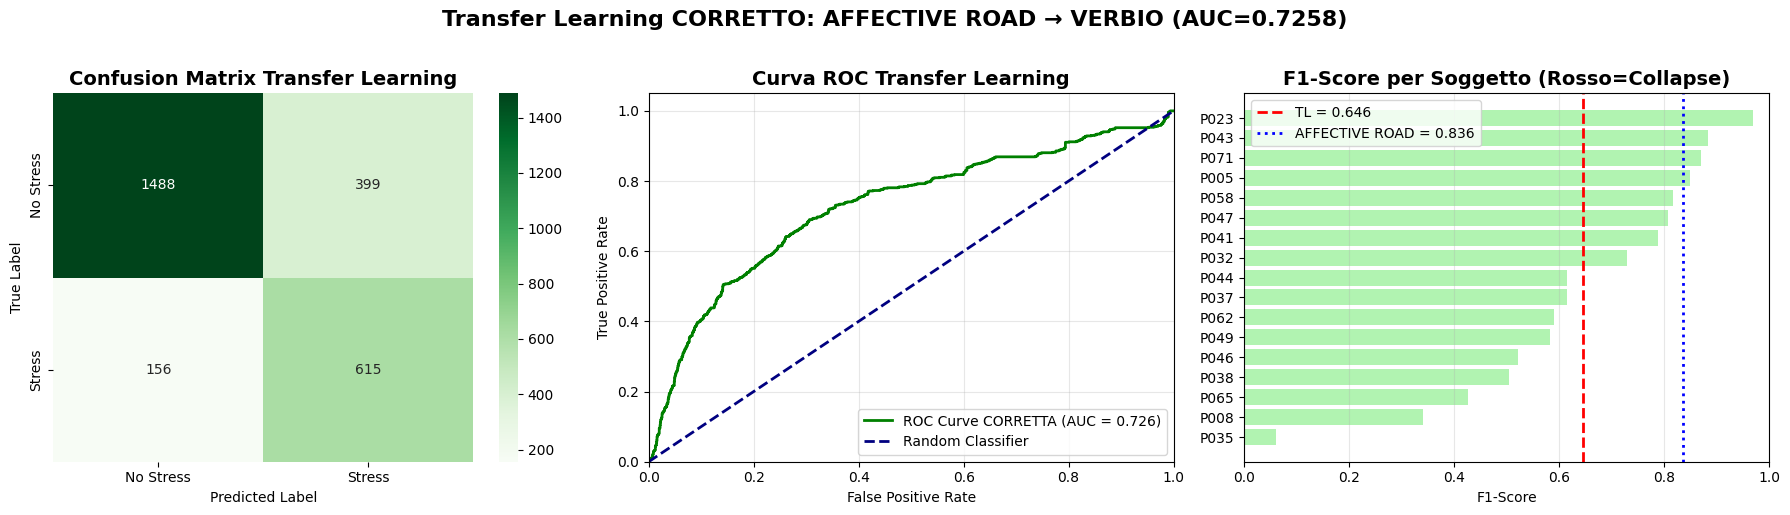


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/VERBIO/AFFECTIVEROAD_TO_VERBIO_RESULTS_FIXED/affectiveroad_to_verbio_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/VERBIO/AFFECTIVEROAD_TO_VERBIO_RESULTS_FIXED/affectiveroad_to_verbio_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: AFFECTIVE ROAD → VERBIO CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO AFFECTIVE ROAD
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV AFFECTIVE ROAD se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/AffectiveRoad Dataset/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/AffectiveRoad Dataset/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV AFFECTIVE ROAD: {e}")
    return None

def load_source_model(model_dir, dataset_name="AFFECTIVE ROAD"):
    """Carica modello sorgente AFFECTIVE ROAD con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello AFFECTIVE ROAD
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON AFFECTIVE ROAD corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello AFFECTIVE ROAD!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers AFFECTIVE ROAD
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente AFFECTIVE ROAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/AFFECTIVE ROAD"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "AFFECTIVE ROAD")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: AFFECTIVE ROAD → VERBIO")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (VERBIO)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per VERBIO
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/VERBIO/AFFECTIVEROAD_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER AFFECTIVE ROAD (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER AFFECTIVE ROAD ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler AFFECTIVE ROAD
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"AFFECTIVE ROAD originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'AFFECTIVE ROAD = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: AFFECTIVE ROAD → VERBIO (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/VERBIO/AFFECTIVEROAD_TO_VERBIO_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "affectiveroad_to_verbio_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'AFFECTIVE ROAD',
        'target_dataset': 'VERBIO',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "affectiveroad_to_verbio_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")